In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
from numpy import linalg
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from pyEulerCurves import difference_ECC
from pyEulerCurves import ECC_from_pointcloud, plot_euler_curve
from sklearn.metrics import pairwise_distances

In [2]:
import scipy
scipy.__version__

'1.7.3'

In [3]:
def exact_ecc_alpha(pointcloud):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    simplices = list(st.get_filtration())
    
    contribs = []
    
    for s in simplices:
        if len(contribs)>0 and s[1] == contribs[-1][0]:
            contribs[-1][1] = contribs[-1][1] + (-1)**(len(s[0])-1)
        else:
            contribs.append([s[1], (-1)**(len(s[0])-1)])       
        
    return contribs

In [4]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

In [5]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in data:
        ec = sampled_ecc_alpha(dat.reshape(-1,1), n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [6]:
def exact_ecc_distance(ECC1, ECC2):
    filtration_steps = list(set(([f[0] for f in ECC1] + [f[0] for f in ECC2] )))
    filtration_steps.sort()
    
    ecc1dict = dict(ECC1)
    ecc2dict = dict(ECC2)
    total_difference = 0
    
    current1val = ecc1dict[0]
    current2val = ecc2dict[0]
    current_difference = np.abs(current1val - current2val)
    
    for i in range(1,len(filtration_steps)):
        total_difference = total_difference + current_difference*(filtration_steps[i]-filtration_steps[i-1])
        if filtration_steps[i] in ecc1dict and filtration_steps[i] in ecc2dict:
            current1val = current1val + ecc1dict[filtration_steps[i]]
            current2val = current2val + ecc2dict[filtration_steps[i]]
        elif filtration_steps[i] in ecc1dict:#but not in ecc2dict
            current1val = current1val + ecc1dict[filtration_steps[i]]
        elif filtration_steps[i] in ecc2dict:#but not in ecc1dict
            current2val = current2val + ecc2dict[filtration_steps[i]]
        
        current_difference = np.abs(current1val - current2val)
        
    
    return total_difference

In [7]:
def ecc_distance_matrix(ECCs1, ECCs2, n_samples, max_filt_val):
    dists = pairwise_distances(ECCs1,ECCs2, n_jobs=-1)
    dists = dists *(max_filt_val/(n_samples-1))
    return dists

/home/nihell/.local/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [10]:
def train_statistics(RV, N, n_samples, n_samples_test, q=0.95):
    samples = [RV.rvs(N) for i in range(n_samples)]
    #if standarize_data:
    #samples_std = [standarize(sample) for sample in samples]
    #samples = samples_std.copy()
    
    eccs = get_ecc(samples, 101,0.1)
    
    W1_train = ecc_distance_matrix(eccs, eccs, 101, 0.1)

    samples_test = [RV.rvs(N) for i in range(n_samples_test)]
    #if standarize_data:
    samples_test_std = [standarize(sample) for sample in samples_test]
    samples_test = samples_test_std.copy()
    
    eccs_test = get_ecc(samples_test, 101, 0.1)
    W1_test = ecc_distance_matrix(eccs, eccs_test, 101, 0.1)

    dmean = np.mean(W1_test, axis=1)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1)
    qmean = np.quantile(dmean, q)
    qmin = np.quantile(dmin, q)
    qmax = np.quantile(dmax, q)
    qq = np.quantile(dq, q)
    return eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq

In [11]:
def standarize(X):
    return (X-np.mean(X))/np.std(X)

def topo_test(samples, eccs, qmin, qmean, qmax, qq):
    #if standarize_data:
    #samples_std = [standarize(sample) for sample in samples]
    #samples = samples_std.copy()
    
    #print("topo_test before ecc")
    eccs_test = get_ecc(samples, 101, 0.1)
    #print("topo_test: got eccs, now compute distances")
    W1_test = ecc_distance_matrix(eccs, eccs_test, 101, 0.1)
    #print("topo_test: distances computed")
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dmean = np.mean(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1) # takie samo q jak w train_statistcs
    
    is_normal_min = dmin < qmin
    is_normal_mean = dmean < qmean
    is_normal_max = dmax < qmax
    is_normal_q = dq < qq
    
    p_empirical_min = np.sum(is_normal_min)/len(is_normal_min)
    p_empirical_mean = np.sum(is_normal_mean)/len(is_normal_mean)
    p_empirical_max = np.sum(is_normal_max)/len(is_normal_max)
    p_empirical_q = np.sum(is_normal_q)/len(is_normal_q)
    #print("topo_test done")
    return p_empirical_min, p_empirical_mean, p_empirical_max, p_empirical_q

def normality_tests(samples):
    def anderson(sample):
        anderson_out = st.anderson(sample, 'norm')
        return anderson_out.statistic < anderson_out.critical_values[2]

    shapiro = [st.shapiro(sample).pvalue >0.05 for sample in samples]
    ks = [st.kstest(sample, 'norm').pvalue >0.05 for sample in samples]
    cvm = [st.cramervonmises(sample, 'norm').pvalue >0.05 for sample in samples]
    ad = [anderson(sample) for sample in samples]
    
    shapiro = np.sum(shapiro)/len(shapiro)
    ks = np.sum(ks)/len(ks)
    ad = np.sum(ad)/len(ad)
    cvm = np.sum(cvm)/len(cvm)
    return shapiro, ks, ad, cvm

In [12]:
# generate other distributions to measure test power
# first check normal distribution
def empirical_test_power(RV, eccs, qmin, qmean, qmax, qq, N=100, n_samples=250):
    samples_topo = [RV.rvs(N) for i in range(n_samples)]
    #mu = RV.stats('m')
    #std = np.sqrt(RV.stats('v'))
    #samples = [(sample-mu)/std for sample in samples_topo]
    samples = [sample for sample in samples_topo]
    #print("in empirical_test_power, after standardizing")
    topo_min, topo_mean, topo_max, topo_q = topo_test(samples_topo, eccs, qmin, qmean, qmax, qq)
    #print("in empirical_test_power, after topo_test")
    power_shapiro, power_ks, power_ad, power_cvm = normality_tests(samples)
    #print("done with empirical_test_power")
    return topo_min, topo_mean, topo_max, topo_q, power_shapiro, power_ks, power_ad, power_cvm

In [13]:
# https://www.semanticscholar.org/paper/Power-comparisons-of-Shapiro-Wilk-%2C-%2C-Lilliefors-Razali-Wah/dcdc0a0be7d65257c4e6a9117f69e246fb227423

rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()

wasserstein_p = 1
wasserstein_order = 1
standarize_data = False

outputfilename = f'results/{standarize_data}_distrib_std_ECC'

rvs = [rv_normal, rv_normal2_2, rv_beta2_2, rv_beta5_5, rv_beta10_10, rv_laplace, rv_uniform, rv_t3, rv_t5, rv_t7, rv_t10, 
       rv_gamma10_1, rv_gamma20_1, rv_gamma4_5, rv_chisq4, rv_chisq10, rv_lorentz]
rv_names = ['Normal01', 'Normal22', 'Beta22', 'Beta55', 'Beta1010', 'Laplace', 'Uniform', 't3', 't5', 't7', 't10', 
            'G10_1', 'G20_1', 'G4_5', 'ChiSq4', 'ChiSq10']    

In [14]:
n_samples = 500
mc_loops = 750
results = defaultdict(list)
resuts_stats = {}

for N in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]:#,1200,1400,1600,1800,2000,2250,2500,2750,3000,3500,4000,5000]:
    # compute the  distance matrix for normal distribution for given data size N
    eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq = train_statistics(rv_normal, N=N, n_samples=n_samples, n_samples_test=750, q=0.95)
    resuts_stats[N] = [eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq]
    
    for rv, rv_name in zip(rvs, rv_names):
        print(f'N={N} rv_name={rv_name}')
        results[rv_name].append([N, *empirical_test_power(RV=rv, eccs=eccs, qmin=qmin, qmean=qmean, qmax=qmax, qq=qq, N=N, n_samples=mc_loops)])
    
    np.save(outputfilename+'AlphaECC.npy', results)
    np.save(outputfilename+'AlphaECC_stats.npy', resuts_stats)

N=50 rv_name=Normal01
N=50 rv_name=Normal22
N=50 rv_name=Beta22
N=50 rv_name=Beta55
N=50 rv_name=Beta1010
N=50 rv_name=Laplace
N=50 rv_name=Uniform
N=50 rv_name=t3
N=50 rv_name=t5
N=50 rv_name=t7
N=50 rv_name=t10
N=50 rv_name=G10_1
N=50 rv_name=G20_1
N=50 rv_name=G4_5
N=50 rv_name=ChiSq4
N=50 rv_name=ChiSq10
N=100 rv_name=Normal01
N=100 rv_name=Normal22
N=100 rv_name=Beta22
N=100 rv_name=Beta55
N=100 rv_name=Beta1010
N=100 rv_name=Laplace
N=100 rv_name=Uniform
N=100 rv_name=t3
N=100 rv_name=t5
N=100 rv_name=t7
N=100 rv_name=t10
N=100 rv_name=G10_1
N=100 rv_name=G20_1
N=100 rv_name=G4_5
N=100 rv_name=ChiSq4
N=100 rv_name=ChiSq10
N=150 rv_name=Normal01
N=150 rv_name=Normal22
N=150 rv_name=Beta22
N=150 rv_name=Beta55
N=150 rv_name=Beta1010
N=150 rv_name=Laplace
N=150 rv_name=Uniform
N=150 rv_name=t3
N=150 rv_name=t5
N=150 rv_name=t7
N=150 rv_name=t10
N=150 rv_name=G10_1
N=150 rv_name=G20_1
N=150 rv_name=G4_5
N=150 rv_name=ChiSq4
N=150 rv_name=ChiSq10
N=200 rv_name=Normal01
N=200 rv_name=N

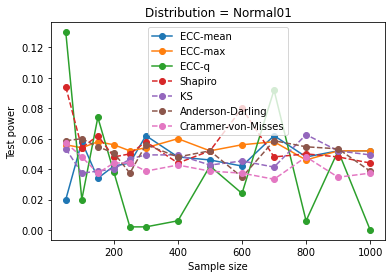

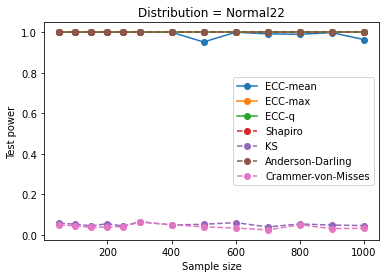

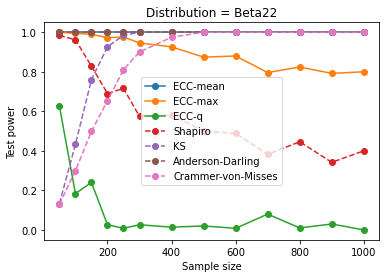

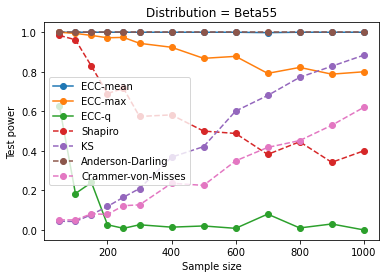

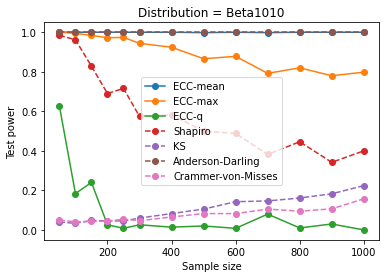

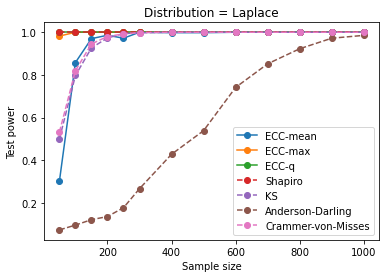

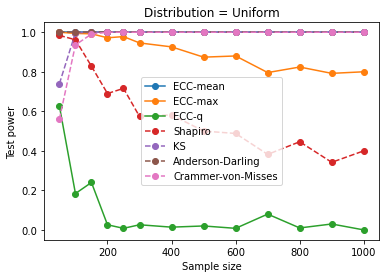

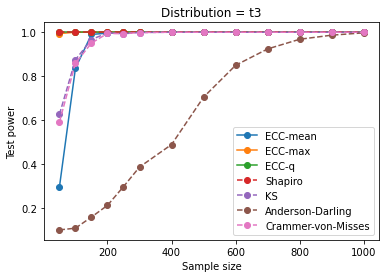

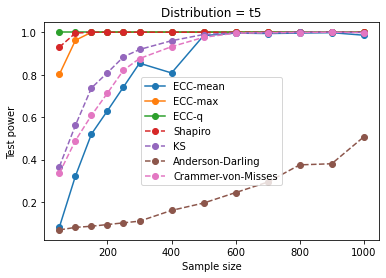

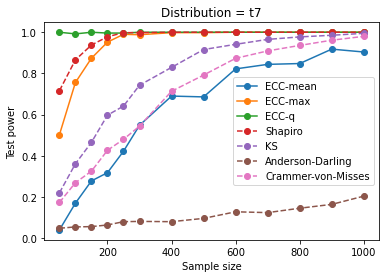

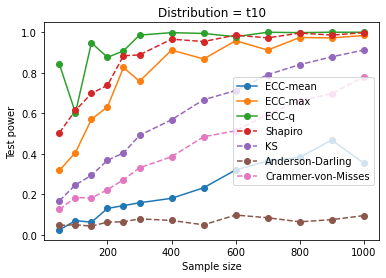

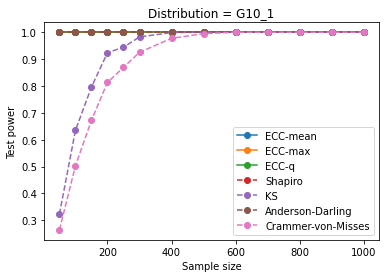

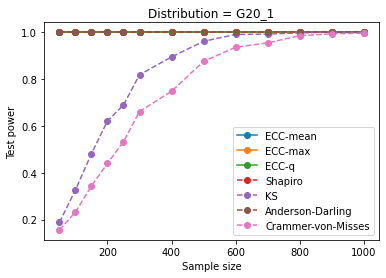

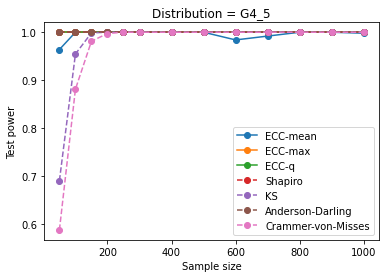

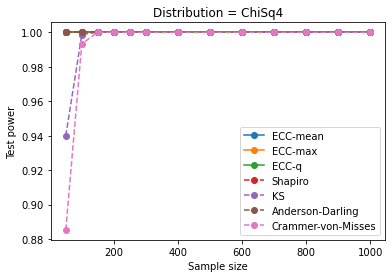

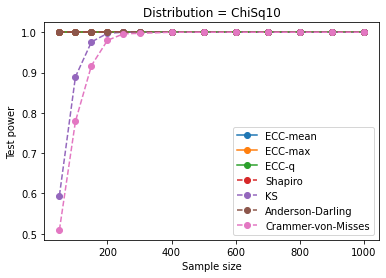

In [15]:
for dist_name in results.keys():
    data = results[dist_name]
    data = np.array(data)
    #plt.plot(data[:, 0], 1-data[:, 0], 'o-', label='ECC-min')
    plt.plot(data[:, 0], 1-data[:, 1], 'o-', label='ECC-mean')
    plt.plot(data[:, 0], 1-data[:, 2], 'o-', label='ECC-max')
    plt.plot(data[:, 0], 1-data[:, 3], 'o-', label='ECC-q')
    plt.plot(data[:, 0], 1-data[:, 4], 'o--', label='Shapiro')
    plt.plot(data[:, 0], 1-data[:, 5], 'o--', label='KS')
    plt.plot(data[:, 0], 1-data[:, 6], 'o--', label='Anderson-Darling')
    plt.plot(data[:, 0], 1-data[:, 7], 'o--', label='Crammer-von-Misses')
    plt.xlabel('Sample size')
    plt.ylabel('Test power')
    plt.title(f'Distribution = {dist_name}')
    plt.legend()
    plt.savefig(outputfilename+'_'+dist_name+'_AlphaECC.png')
    plt.show()

In [18]:
qmin

0.006557438524302001